# Denoising Diffusion Probabilistic Model in 1 Dimension

In [1]:
# !pip install seaborn

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from numpy import random
import random as rd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Create a biomodal dataset

In [71]:
from torch.distributions import Categorical, Dirichlet, Normal, MultivariateNormal
from typing import List


def sample_gmm_2d(means: List[List[float]], scales: List[float], mixing_coefficients: List[float], concentration: float, N: int = 1000):
    assert len(means) == len(scales) == len(mixing_coefficients)
    assert all(len(mean) == 2 for mean in means)
    assert sum(mixing_coefficients) == 1

    means = [torch.tensor(mean) for mean in means]
    scale_trils = [torch.diag(scale * torch.ones(2,)) for scale in scales]

    dirichlet = Dirichlet(concentration * torch.ones(len(means)))
    cat = Categorical(dirichlet.sample())
    mvns = [MultivariateNormal(means[comp], scale_tril=scale_trils[comp]) for comp in range(len(means))]
    
    return torch.cat([
        mvns[cat.sample()].sample().unsqueeze(0)
        for _ in range(N)
    ])

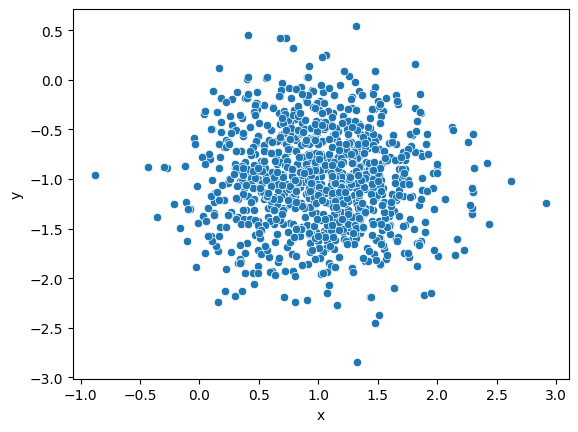

In [84]:
means = [[-1., -1.], [0., 1.], [1., -1.]]
len_means = len(means)
gmm_kwargs = {
    "means": means,
    "scales": [0.5] * len_means,
    "mixing_coefficients": [1 / len_means] * len_means,
    "concentration": 0.01,
    "N": 1000,
}
sns.scatterplot(
    pd.DataFrame(sample_gmm_2d(**gmm_kwargs), columns=["x", "y"]),
    x="x",
    y="y",
)
plt.show()

## Diffusion process

In [59]:
import math
from pathlib import Path
from functools import partial
from collections import namedtuple
from typing import List, Optional, Tuple

import torch
from torch import nn, einsum, Tensor
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from einops import rearrange, reduce, repeat

import numpy as np

from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset


class Custom_Dataset(Dataset):
    def __init__(self, _dataset, _conds):
        self.dataset = _dataset
        self.conds = _conds

    def __getitem__(self, index):
        example = self.dataset[index]
        cond = self.conds[index]
        return np.array(example), np.array(cond)

    def __len__(self):
        return len(self.dataset)


# helpers functions
def exists(x):
    return x is not None


def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d


# small helper modules
def Upsample(dim: int, dim_out: Optional[int] = None) -> nn.Module:
    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode="nearest"),
        nn.Conv1d(dim, default(dim_out, dim), 3, padding=1)
    )


def Downsample(dim: int, dim_out: Optional[int] = None) -> nn.Module:
    return nn.Conv1d(dim, default(dim_out, dim), 4, 2, 1)


# sinusoidal positional embeds
class SinusoidalPosEmb(nn.Module):
    
    def __init__(self, dim: int, theta: int = 10000):
        super().__init__()
        self.dim = dim
        self.theta = theta

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(self.theta) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


# building block modules
class Block(nn.Module):
    
    def __init__(self, dim: int, dim_out: int, groups: int = 8):
        super().__init__()
        self.proj = nn.Conv1d(dim, dim_out, 3, padding=1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(
        self,
        x: torch.FloatTensor,
        scale_shift: Optional[Tuple[torch.FloatTensor, torch.FloatTensor]] = None,
    ) -> torch.FloatTensor:
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x


class ResnetBlock(nn.Module):
    def __init__(self, dim: int, dim_out: int, time_emb_dim: Optional[int] = None, groups: int = 8):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, dim_out * 2)
        ) if exists(time_emb_dim) else None
        self.block1 = Block(dim, dim_out, groups = groups)
        self.block2 = Block(dim_out, dim_out, groups = groups)
        self.res_conv = nn.Conv1d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x: torch.FloatTensor, time_emb: torch.FloatTensor = None) -> torch.FloatTensor:
        scale_shift = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, "b c -> b c 1")
            scale_shift = time_emb.chunk(2, dim = 1)
            
        h = self.block1(x, scale_shift=scale_shift)
        h = self.block2(h)
        h = h + self.res_conv(x)
        return h


class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x


class RMSNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.g = nn.Parameter(torch.ones(1, dim, 1))

    def forward(self, x):
        return F.normalize(x, dim = 1) * self.g * (x.shape[1] ** 0.5)


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = RMSNorm(dim)

    def forward(self, x, *args, **kwargs):
        x = self.norm(x)
        return self.fn(x, *args, **kwargs)


class CrossAttention(nn.Module):
    def __init__(self, dim, heads = 4, dim_head = 32, context_dim = 512):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads

        self.to_q = nn.Conv1d(dim, hidden_dim, 1, bias = False)
        self.to_kv = nn.Conv1d(context_dim, hidden_dim * 2, 1, bias = False)
        self.to_qkv = nn.Conv1d(dim, hidden_dim * 3, 1, bias = False)
        self.to_out = nn.Conv1d(hidden_dim, dim, 1)

    def forward(self, x, context=None):
        b, c, n = x.shape
        if context is None:
            q, k, v = self.to_qkv(x).chunk(3, dim = 1)
        else:
            q, k, v = self.to_q(x), *self.to_kv(context).chunk(2, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) n -> b h c n', h = self.heads), (q, k, v))

        sim = einsum('b h d i, b h d j -> b h i j', q, k)
        attn = sim.softmax(dim = -1)
        out = einsum('b h i j, b h d j -> b h i d', attn, v)

        out = rearrange(out, 'b h n d -> b (h d) n')
        return self.to_out(out)


class Unet1d(nn.Module):
    
    def __init__(
        self,
        dim: int,
        dim_mults: List[int] = [1, 2, 4, 8],
        channels: int = 1,
        resnet_block_groups: int = 8,
        learned_sinusoidal_dim: int = 16,
        sinusoidal_pos_emb_theta: int = 10000,
        context_dim: int = 2,
    ):
        super().__init__()

        # determine dimensions
        dims = [dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))
        out_dim = channels
        mid_dim = dims[-1]
        num_resolutions = len(in_out)
        
        # time embeddings
        time_dim = dim * 4
        sinu_pos_emb = SinusoidalPosEmb(dim, theta=sinusoidal_pos_emb_theta)
        fourier_dim = dim
        self.time_mlp = nn.Sequential(
            sinu_pos_emb,
            nn.Linear(fourier_dim, time_dim),
            nn.ReLU(),
            nn.Linear(time_dim, time_dim)
        )

        # layers
        block_klass = partial(ResnetBlock, groups=resnet_block_groups)
        
        self.init_conv = nn.Conv1d(channels, dim, 7, padding=3)
        
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)
            self.downs.append(nn.ModuleList([
                block_klass(dim_in, dim_in, time_emb_dim = time_dim),
                Residual(PreNorm(dim_out, CrossAttention(dim_out, dim_head=32, heads=4, context_dim=context_dim))),
                Downsample(dim_in, dim_out) if not is_last else nn.Conv1d(dim_in, dim_out, 3, padding=1)
            ]))

        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, CrossAttention(mid_dim, dim_head=32, heads=4, context_dim=context_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)
            self.ups.append(nn.ModuleList([
                block_klass(dim_out + dim_in, dim_out, time_emb_dim = time_dim),
                Residual(PreNorm(dim_out, CrossAttention(dim_out, dim_head=32, heads=4, context_dim=context_dim))),
                Upsample(dim_out, dim_in) if not is_last else nn.Conv1d(dim_out, dim_in, 3, padding=1)
            ]))

        self.final_res_block = block_klass(dim * 2, dim, time_emb_dim=time_dim)
        self.final_conv = nn.Conv1d(dim, out_dim, 1)

    def forward(self, x, time, cond):
        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(time)

        h = []
        for block, attn, downsample in self.downs:
            x = block(x, t)
            x = attn(x, cond)
            h.append(x)
            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x, cond)
        x = self.mid_block2(x, t)
        
        for block, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block(x, t)
            x = attn(x, cond)
            x = upsample(x)

        x = torch.cat((x, r), dim = 1)
        x = self.final_res_block(x, t)
        x = self.final_conv(x)

        return x

In [60]:
# import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm.auto import tqdm


class StableDiffusion1d:
    
    def __init__(self, unet: Unet1d, time_steps: int, sample_steps: int):
        self.unet = unet
        self.device = next(unet.parameters()).device
        
        self.time_steps = time_steps
        # sample_steps < time_steps
        self.sample_steps = sample_steps
        self.tau = torch.linspace(self.time_steps - 1, 0, (self.sample_steps + 1)).long().to(self.device)
        self.betas = self._linear_beta_schedule().to(self.device)

        self.alphas = 1. - self.betas
        self.alphas_bar = torch.cumprod(self.alphas, axis=0)
        self.alphas_bar_prev = F.pad(self.alphas_bar[:-1], (1, 0), value=1.0)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)
        self.sqrt_recip_alphas_prev = F.pad(self.sqrt_recip_alphas[:-1], (1, 0), value=1.0)
        self.sqrt_alphas_bar = torch.sqrt(self.alphas_bar)
        self.sqrt_alphas_bar_prev = F.pad(self.sqrt_alphas_bar[:-1], (1, 0), value=1.0)
        self.sqrt_minus_alphas_bar = torch.sqrt(1. - self.alphas_bar)
        self.sqrt_minus_alphas_bar_prev = F.pad(self.sqrt_minus_alphas_bar[:-1], (1, 0), value=1.0)
        self.posterior_variance = self.betas * (1. - self.alphas_bar_prev) / (1. - self.alphas_bar)
    
    def _get_index_from_list(self, vals: torch.Tensor, t: torch.Tensor, x_shape: torch.Size) -> torch.Tensor:
        """ helper function to get index from list, considering batch dimension
        
        Args:
            vals (torch.Tensor): list of values
            t (torch.Tensor): timestep
            x_shape (torch.Size): shape of input image

        Returns:
            torch.Tensor: value at timestep t
        """
        batch_size = t.shape[0] # batch_size
        out = vals.gather(-1, t) # (batch_size, 1)
        return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)
    
    def _linear_beta_schedule(self, start=0.0001, end=0.02) -> torch.Tensor:
        """ linear beta schedule
        Args:
            start (float, optional): beta at timestep 0. Defaults to 0.0001.
            end (float, optional): beta at last timestep. Defaults to 0.02.

        Returns:
            torch.Tensor: beta schedule
        """
        return torch.linspace(start, end, self.time_steps)
    
    def forward(self, x_0: torch.Tensor, t: torch.Tensor, type='forecast'):
        """ forward process of diffusion model
        Args:
            x_0 (torch.Tensor): input image
            t (torch.Tensor): timestep
            
        Returns:
            tuple[torch.Tensor, torch.Tensor]: noisy image and noise
        """
        noise = torch.randn_like(x_0).to(self.device)
        
        sqrt_alphas_cumprod_t = self._get_index_from_list(
            self.sqrt_alphas_bar, t, x_0.shape
        )
        sqrt_one_minus_alphas_cumprod_t = self._get_index_from_list(
            self.sqrt_minus_alphas_bar, t, x_0.shape
        )
        # mean + variance
        return sqrt_alphas_cumprod_t.to(self.device) * x_0.to(self.device) \
            + sqrt_one_minus_alphas_cumprod_t.to(self.device) * noise.to(self.device), \
            noise.to(self.device)
            
    @torch.no_grad()
    def sample_timestep(self, x: torch.Tensor, t: torch.Tensor, cond) -> torch.Tensor:
        """
        Calls the model to predict the noise in the image and returns 
        the denoised image. 
        Applies noise to this image, if we are not in the last step yet.
        """
        betas_t = self._get_index_from_list(self.betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = self._get_index_from_list(
            self.sqrt_minus_alphas_bar, t, x.shape
        )
        sqrt_recip_alphas_t = self._get_index_from_list(self.sqrt_recip_alphas, t, x.shape)
        
        # Call model (current image - noise prediction)
        model_mean = sqrt_recip_alphas_t * (
            x - betas_t * self.unet(x, t, cond) / sqrt_one_minus_alphas_cumprod_t
        )
        posterior_variance_t = self._get_index_from_list(self.posterior_variance, t, x.shape)
        
        if t == 0:
            # As pointed out by Luis Pereira (see YouTube comment)
            # The t's are offset from the t's in the paper
            return model_mean
        else:
            noise = torch.randn_like(x)
            return model_mean + torch.sqrt(posterior_variance_t) * noise
        
    @torch.no_grad()
    def sampling(self, x_T: torch.Tensor, cond) -> torch.Tensor:
        """ sampling process of diffusion model
        Args:
            x_T (torch.Tensor): input image (gaussian noise)
            
        Returns:
            torch.Tensor: denoised image
        """
        x = x_T
        for i in tqdm(reversed(range(self.time_steps)), desc="Sampling"):
            t = torch.full((x.shape[0],), i, dtype=torch.long, device=self.device)
            x = self.sample_timestep(x, t, cond)
        return x
    
    @torch.no_grad()
    def sampling_sequence(self, x_shape: torch.Size, obs) -> np.ndarray:
        x_T = torch.randn(x_shape).to(self.device)
        sampled_tensor = self.sampling(x_T, obs)
        return sampled_tensor

    @torch.no_grad()
    def sample_timestep_guidance(self, condition, guidance_scale, x, itau):
        t = torch.full((x.shape[0],), self.tau[itau].item(), dtype=torch.long, device=self.device)
        sqrt_alphas_bar = self._get_index_from_list(self.sqrt_alphas_bar, t, x.shape)
        sqrt_minus_alphas_bar = self._get_index_from_list(self.sqrt_minus_alphas_bar, t, x.shape)
        alphas_bar = self._get_index_from_list(self.alphas_bar, t, x.shape)        

        if itau != self.sample_steps:
            t_prev = torch.full((x.shape[0],), self.tau[itau + 1].item(), dtype=torch.long, device=self.device)
            sqrt_alphas_bar_prev = self._get_index_from_list(self.sqrt_alphas_bar, t_prev, x.shape)
            alphas_bar_prev = self._get_index_from_list(self.alphas_bar, t_prev, x.shape)

        # classifier free guidance - equation 6
        eps_uncond = self.unet(x, t, None)
        eps_cond = self.unet(x, t, condition)
        eps = eps_uncond + guidance_scale * (eps_cond - eps_uncond)

        # DDIM - equation 9
        if itau == self.sample_steps:
            f_theta = (x - sqrt_minus_alphas_bar * eps) / sqrt_alphas_bar
            return f_theta

        # DDIM - paragraphs below equation 12
        eta = 0.0
        sigma_t = eta \
            * torch.sqrt((1 - alphas_bar_prev) / (1 - alphas_bar)) \
            * torch.sqrt((1 - alphas_bar / alphas_bar_prev))

        # DDIM - equation 12 
        predicted_x0 = sqrt_alphas_bar_prev * (x - sqrt_minus_alphas_bar * eps) / sqrt_alphas_bar
        towards_xt = torch.sqrt(1 - alphas_bar_prev - sigma_t ** 2) * eps
        noise = torch.randn_like(x) if t > 0 else 0
        x_prev = predicted_x0 + towards_xt + sigma_t * noise

        return x_prev

    @torch.no_grad()
    def inverse_timestep_guidance(self, condition, guidance_scale, x, itau):
        t = torch.full((x.shape[0],), self.tau[itau].item(), dtype=torch.long, device=self.device)
        sqrt_alphas_bar = self._get_index_from_list(self.sqrt_alphas_bar, t, x.shape)
        sqrt_minus_alphas_bar = self._get_index_from_list(self.sqrt_minus_alphas_bar, t, x.shape)
        alphas_bar = self._get_index_from_list(self.alphas_bar, t, x.shape)        

        if itau != self.sample_steps:
            t_prev = torch.full((x.shape[0],), self.tau[itau + 1].item(), dtype=torch.long, device=self.device)
            sqrt_alphas_bar_prev = self._get_index_from_list(self.sqrt_alphas_bar, t_prev, x.shape)
            alphas_bar_prev = self._get_index_from_list(self.alphas_bar, t_prev, x.shape)

        # classifier free guidance - equation 6
        eps_uncond = self.unet(x, t, None)
        eps_cond = self.unet(x, t, condition)
        eps = eps_uncond + guidance_scale * (eps_cond - eps_uncond)

        # DDIM - equation 9
        if itau == self.sample_steps:
            f_theta = (x - sqrt_minus_alphas_bar * eps) / sqrt_alphas_bar
            return f_theta

        # DDIM - paragraphs below equation 12
        eta = 0.0
        sigma_t = eta \
            * torch.sqrt((1 - alphas_bar_prev) / (1 - alphas_bar)) \
            * torch.sqrt((1 - alphas_bar / alphas_bar_prev))

        # DDIM - equation 12
        predicted_x0 = sqrt_alphas_bar_prev * (x - sqrt_minus_alphas_bar * eps) / sqrt_alphas_bar
        towards_xt = torch.sqrt(1 - alphas_bar_prev - sigma_t ** 2) * eps
        noise = torch.randn_like(x) if t > 0 else 0
        x_prev = predicted_x0 + towards_xt + sigma_t * noise

        return x_prev
    
    @torch.no_grad()
    def sampling_guided(self, x_T: torch.Tensor, condition, guidance_scale) -> torch.Tensor:
        """ sampling process of diffusion model
        Args:
            x_T (torch.Tensor): input image (gaussian noise)
            
        Returns:
            torch.Tensor: denoised image
        """
        x = x_T
        eta = 1
        for i in tqdm(range(1, self.sample_steps + 1), desc='DDIM Sampling'):
            itau = torch.full((x.shape[0],), i, dtype=torch.long, device=self.device)
            x = self.sample_timestep_guidance(condition, guidance_scale, x, itau)
        return x

    # DDIM
    @torch.no_grad()
    def sampling_guided_sequence(self, x_shape, condition, guidance_scale) -> np.ndarray:
        torch.manual_seed(2333)
        x_T = torch.randn(x_shape).to(self.device)
        sampled_tensor = self.sampling_guided(x_T, condition, guidance_scale)
        sampled_seq = sampled_tensor.squeeze().detach().cpu().numpy()
        return sampled_seq

In [93]:
F.pad(torch.tensor([1,2,3,4,5,6])[1:], (1, 0), value=1.0)

tensor([1, 2, 3, 4, 5, 6])

In [61]:
# https://github.com/lantel-wm/1d_ddpm/blob/main/ddpm/diffusion1d.py

class Trainer:
    
    def __init__(
        self,
        diffuser: StableDiffusion1d,
        epochs: int,
        uncond_prob: float = 0.25,
    ) -> None:    
        self.diffuser = diffuser
        self.T = self.diffuser.time_steps
        self.forward_diffusion_sample = self.diffuser.forward
        self.unet = self.diffuser.unet
        self.device = next(self.unet.parameters()).device
        self.sampler = self.diffuser.sampling_sequence
        self.model_save_dir = "results"
        self.optimizer = torch.optim.Adam(self.unet.parameters(), lr=1e-5)
        self.epochs = epochs
        self.uncond_prob = uncond_prob
    
    def get_loss(self, x_0, t, cond):
        x_noisy, noise = self.forward_diffusion_sample(x_0, t)
        noise_pred = self.unet(x_noisy, t, cond)
        return F.l1_loss(noise, noise_pred)
    
    def save_model_weight(self, epoch):
        torch.save(self.unet.state_dict(), f'{self.model_save_dir}/model_{epoch}.pt')
        
    def save_sampled_image(self, epoch, x_shape: torch.Size):
        sampled_img = self.sampler(x_shape, 'image')
        cv2.imwrite(f"{self.model_save_dir}/sampled_{epoch}.jpg", sampled_img)
        
    def save_sampled_sequence(self, epoch, x_shape: torch.Size, obs = None):
        sampled_seq = self.sampler(x_shape)
        sampled_seq = sampled_seq.squeeze().detach().cpu().numpy()
        plt.plot(sampled_seq)
        plt.savefig(f"{self.model_save_dir}/sampled_seq_{epoch}.jpg")
        plt.close()
        
    def train(self, dataloader):
        for epoch in range(self.epochs):
            loop = tqdm(dataloader, desc=f"Epoch {epoch}")
            # losses = []
            obs_for_sample = None
            for data, cond in loop:
                self.optimizer.zero_grad()
                # [0, T)
                batch_size, channels, dimension = data.shape
                t = torch.randint(0, self.T, (batch_size,)).to(self.device).long()
                data = data.to(self.device)
                cond = None if torch.rand(1) < self.uncond_prob else cond.to(self.device)
                # print(data.device, data.shape, cond.device, cond.shape)
                loss = self.get_loss(data, t, cond)
                loss.backward()
                self.optimizer.step()
                loop.set_postfix(loss=loss.item(), t=t[0].item())

## 2D Bimodal

In [62]:
unet = Unet1d(
    dim=20,
    resnet_block_groups=5,
    dim_mults=(1,),
    channels=2,
).to(device)
diffuser = StableDiffusion1d(unet, 100, 10)
trainer = Trainer(
    diffuser, 100,
)

In [73]:
from tqdm import tqdm

training_data_2d = [sample_gmm_2d(**gmm_kwargs).unsqueeze(0).transpose(1, 2) for _ in tqdm(range(1000))]
training_data_2d_conds = torch.cat([data.squeeze(0).mean(axis=1).unsqueeze(0) for data in training_data_2d]).unsqueeze(-1)
training_data_2d = torch.cat(training_data_2d)


  0%|                                                                                                                     | 0/1000 [04:39<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:24<00:00, 11.81it/s]


In [74]:
train_loader = DataLoader(
    dataset=Custom_Dataset(training_data_2d, training_data_2d_conds),
    batch_size=128,
    shuffle=True,
)
trainer.train(train_loader)

Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 22.20it/s, loss=0.592, t=84]


DDIM Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 139.27it/s]


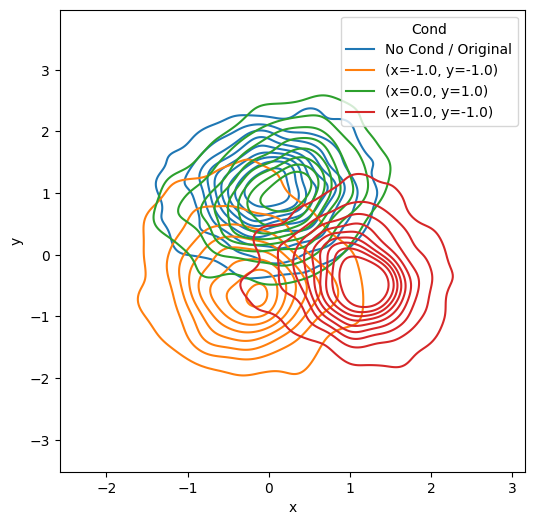

In [80]:
dfs = []

i = 13
data_point = training_data_2d[i]
original = pd.DataFrame(data_point.transpose(0, 1), columns=["x", "y"])
original["Cond"] = "No Cond / Original"
dfs.append(original)

data_point = data_point.unsqueeze(0).to(device)
data_point_cond = training_data_2d_conds[i].unsqueeze(0).to(device)
x_noisy, _ = diffuser.forward(data_point, torch.tensor((99,)).to(device))
guidance_scale = 7.5

for mean in gmm_kwargs["means"]:
    cond = torch.tensor(mean).view(1, 2, 1).to(device)
    sample_guided = diffuser.sampling_guided(x_noisy, cond, guidance_scale).squeeze(0).transpose(0, 1).cpu()
    df = pd.DataFrame(sample_guided, columns=["x", "y"])
    df["Cond"] = f"(x={mean[0]}, y={mean[1]})"
    dfs.append(df)

fig, ax = plt.subplots(figsize=(6, 6))
dfs = pd.concat(dfs)
sns.kdeplot(
    dfs,
    x="x",
    y="y",
    hue="Cond",
    ax=ax
)

plt.show()